In [46]:
import os
import re
import glob
from typing import Tuple
from chaos_hunter.utils.functions import load_json
from chaos_hunter.chaos_hunter import ChaosHunterOutput

def get_tokens(ce_output: ChaosHunterOutput, phase_name: str) -> Tuple[int, int, int]:
    logs = ce_output.logs[phase_name]
    input_tokens = 0
    output_tokens = 0
    total_tokens = 0
    for log in logs:
        if isinstance(log, list):
            for log_ in log:
                token_usage = log_.token_usage
                input_tokens += token_usage.input_tokens
                output_tokens += token_usage.output_tokens
                total_tokens += token_usage.total_tokens    
        else:
            token_usage = log.token_usage
            input_tokens += token_usage.input_tokens
            output_tokens += token_usage.output_tokens
            total_tokens += token_usage.total_tokens
    return input_tokens, output_tokens, total_tokens

def get_runtime(ce_output: ChaosHunterOutput, phase_name: str) -> float:
    run_time = ce_output.run_time[phase_name]
    if isinstance(run_time, list):
        total_run_time = 0.
        for run_time_ in run_time:
            total_run_time += run_time_
        return total_run_time
    else:
        return ce_output.run_time[phase_name]
    
def get_dict_list():
    return {
        "preprocess": [],
        "hypothesis": [],
        "experiment": [],
        "analysis": [],
        "improvement": [],
        "summary": [],
        "total": []
    }

def extract_number(filename: str) -> int:
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group(0))
    return None



RESULT_DIR = "results"
MODELS = ["openai/gpt-4o-2024-08-06"] #, "google/gemini-1.5-pro", "anthropic/claude-3-5-sonnet-20240620"]
SAMPLES = ["nginx", "sockshop"]


for sample in SAMPLES:
    input_tokens = {}
    output_tokens = {}
    total_tokens = {}
    run_time = {}
    completion = {}
    score = {}
    reconfig_rate = {}
    for model in MODELS:
        #----------------
        # initialization
        #----------------
        input_tokens[model] = get_dict_list()
        output_tokens[model] = get_dict_list()
        total_tokens[model] = get_dict_list()
        run_time[model] = get_dict_list()
        completion[model] = get_dict_list()
        score[model] = get_dict_list()
        reconfig_rate[model] = []
        
        def add_metrics(phase_name: str):
            if phase_name == "experiment":
                input_tokens_, output_tokens_, total_tokens_ = get_tokens(ce_output, "experiment_plan")
                run_time_ = get_runtime(ce_output, "experiment_plan") + get_runtime(ce_output, "experiment_execution")
            else:
                input_tokens_, output_tokens_, total_tokens_ = get_tokens(ce_output, phase_name)
                run_time_ = get_runtime(ce_output, phase_name)
            completion[model][phase_name].append(True)
            input_tokens[model][phase_name].append(input_tokens_)
            output_tokens[model][phase_name].append(output_tokens_)
            total_tokens[model][phase_name].append(total_tokens_)
            run_time[model][phase_name].append(run_time_)
            return input_tokens_, output_tokens_, total_tokens_,
    
        #-------------
        # aggregation
        #-------------
        result_paths = [f"results/{model.split('/')[-1]}-{sample}-{i}/outputs/output.json" for i in range(1, 6)]
        # loop over samples
        for path in result_paths:
            ce_output = ChaosHunterOutput(**load_json(path))
            #---------------
            # preprocessing
            #---------------
            if ce_output.ce_cycle.processed_data is not None:
                preprocess_input_tokens, preprocess_output_tokens, preprocess_total_tokens = add_metrics("preprocess")
            else:
                completion[model]["preprocess"].append(False)
                completion[model]["hypothesis"].append(False)
                completion[model]["experiment"].append(False)
                completion[model]["analysis"].append(False)
                completion[model]["improvement"].append(False)
                completion[model]["summary"].append(False)
                completion[model]["total"].append(False)
                continue
                
            #------------
            # hypothesis
            #------------
            if ce_output.ce_cycle.hypothesis is not None:
                hypothesis_input_tokens, hypothesis_output_tokens, hypothesis_total_tokens = add_metrics("hypothesis")
            else:
                completion[model]["experiment"].append(False)
                completion[model]["analysis"].append(False)
                completion[model]["improvement"].append(False)
                completion[model]["hypothesis"].append(False)
                completion[model]["summary"].append(False)
                completion[model]["total"].append(False)
                continue
    
            #------------------
            # Improvement loop
            #------------------  
            if ce_output.ce_cycle.completes_reconfig:
                #------------
                # experiment
                #------------
                exp_input_tokens, exp_output_tokens, exp_total_tokens = add_metrics("experiment")
                
                #----------
                # analysis
                #----------
                if len(ce_output.ce_cycle.analysis_history) > 0:
                    analysis_input_tokens, analysis_output_tokens, analysis_total_tokens = add_metrics("analysis")
                else:
                    completion[model]["analysis"].append(True)
                    analysis_input_tokens, analysis_output_tokens, analysis_total_tokens = 0, 0, 0
                
                #-------------
                # improvement
                #-------------    
                if len(ce_output.ce_cycle.reconfig_history) > 0:
                    improve_input_tokens, improve_output_tokens, improve_total_tokens = add_metrics("improvement")
                else:
                    completion[model]["improvement"].append(True)
                    improve_input_tokens, improve_output_tokens, improve_total_tokens = 0, 0, 0
    
                #---------------
                # reconfig rate
                #---------------
                if ce_output.ce_cycle.conducts_reconfig:
                    reconfig_rate[model].append(True)
                else:
                    reconfig_rate[model].append(False)
            else:
                completion[model]["experiment"].append(False)
                completion[model]["analysis"].append(False)
                completion[model]["improvement"].append(False)
                completion[model]["summary"].append(False)
                completion[model]["total"].append(False)
                continue
    
            
            #----------------
            # postprocessing
            #----------------
            if ce_output.ce_cycle.summary != "":
                summary_input_tokens, summary_output_tokens, summary_total_tokens = add_metrics("summary")
            else:
                completion[model]["summary"].append(False)
                completion[model]["total"].append(False)
                continue
    
            #-------
            # total
            #-------
            if "cycle" in ce_output.run_time:
                completion[model]["total"].append(True)
                if ce_output.ce_cycle.conducts_reconfig:
                    run_time[model]["total"].append(ce_output.run_time["cycle"])
                    input_tokens[model]["total"].append(preprocess_input_tokens + hypothesis_input_tokens + exp_input_tokens + analysis_input_tokens + improve_input_tokens + summary_input_tokens)
                    output_tokens[model]["total"].append(preprocess_output_tokens + hypothesis_output_tokens + exp_output_tokens + analysis_output_tokens + improve_output_tokens + summary_output_tokens)
                    total_tokens[model]["total"].append(preprocess_total_tokens + hypothesis_total_tokens + exp_total_tokens + analysis_total_tokens + improve_total_tokens + summary_total_tokens)
            else:
                completion[model]["total"].append(False)
    
            #-----------------
            # reviewing score
            #-----------------
            # result_number = extract_number(os.path.basename(path))
            # hypothesis_scores = []
            # experiment_scores = []
            # analysis_scores = []
            # improvement_scores = []
            # overall_scores = []
            # for reviewer in REVIEWERS:
            #     review_path = f"{result_dir}/review{result_number}_{reviewer.split('/')[-1]}.json"
            #     review = load_json(review_path)
            #     hypothesis_scores.append(review["hypothesis"]["score"])
            #     experiment_scores.append(review["experiment"]["score"])
            #     analysis_scores.append(review["analysis"]["score"])
            #     improvement_scores.append(review["improvement"]["score"])
            #     overall_scores.append(review["overall"]["score"])
            # score[model]["hypothesis"].append(hypothesis_scores)
            # score[model]["experiment"].append(experiment_scores)
            # score[model]["analysis"].append(analysis_scores)
            # score[model]["improvement"].append(improvement_scores)
            # score[model]["total"].append(overall_scores)
    print("sample:", sample)
    print("input_tokens", input_tokens)
    print("output_tokens", output_tokens)
    print("total_tokens", total_tokens)
    print("run_time", run_time)
    print("completion", completion)
    print("review", score)
    print("reconfig_rate", reconfig_rate)
    print()

sample: nginx
input_tokens {'openai/gpt-4o-2024-08-06': {'preprocess': [2579, 2583, 2593, 2601, 2578], 'hypothesis': [25560, 25217, 25667, 25345, 25304], 'experiment': [13341, 13039, 13263, 13321, 13397], 'analysis': [4579, 4383, 4232, 4449, 4411], 'improvement': [5611, 5466, 5279, 5454, 5499], 'summary': [8279, 7980, 8107, 8294, 8258], 'total': [59949, 58668, 59141, 59464, 59447]}}
output_tokens {'openai/gpt-4o-2024-08-06': {'preprocess': [469, 457, 486, 488, 459], 'hypothesis': [2503, 2515, 2542, 2496, 2561], 'experiment': [1780, 1571, 1752, 1683, 1675], 'analysis': [580, 632, 601, 552, 636], 'improvement': [264, 249, 239, 234, 254], 'summary': [389, 331, 381, 313, 409], 'total': [5985, 5755, 6001, 5766, 5994]}}
total_tokens {'openai/gpt-4o-2024-08-06': {'preprocess': [3048, 3040, 3079, 3089, 3037], 'hypothesis': [28063, 27732, 28209, 27841, 27865], 'experiment': [15121, 14610, 15015, 15004, 15072], 'analysis': [5159, 5015, 4833, 5001, 5047], 'improvement': [5875, 5715, 5518, 5688, 5

In [47]:
import pandas as pd
import statistics
import itertools
from chaos_hunter.utils.llms import PRICING_PER_TOKEN

def mean_list(lst: list) -> float:
    if len(lst) > 0:
        if isinstance(lst[0], list):
            return statistics.mean(list(itertools.chain.from_iterable(lst)))
        else:
            return statistics.mean(lst)
    else:
        return -1

rows = []
for phase in ["total", "preprocess", "hypothesis", "experiment", "analysis", "improvement", "summary"]:
    for model in MODELS:
        run_time_mean = mean_list(run_time[model][phase])
        input_tokens_mean = mean_list(input_tokens[model][phase])
        output_tokens_mean = mean_list(output_tokens[model][phase])
        billing_mean = PRICING_PER_TOKEN[model]["input"] * input_tokens_mean + PRICING_PER_TOKEN[model]["output"] * output_tokens_mean
        completion_mean = mean_list(completion[model][phase])
        score_mean = mean_list(score[model][phase])
        row = {
            "Phase": phase.capitalize(),
            "Model": model.split('/')[-1],
            "Time": run_time_mean if run_time_mean <= 60 else run_time_mean/60,
            "Tokens ($)": f"{input_tokens_mean/1000}/{output_tokens_mean/1000} ({billing_mean:.3f})",
            "Completion": completion_mean,
        }
        rows.append(row)
df = pd.DataFrame(rows)
df

,Phase,Model,Time,Tokens ($),Completion
0,Total,gpt-4o-2024-08-06,24.782558,283.9565/13.18 (0.842),1
1,Preprocess,gpt-4o-2024-08-06,4.555809,30.1676/5.6662 (0.132),1
2,Hypothesis,gpt-4o-2024-08-06,4.267725,149.6586/3.836 (0.413),1
3,Experiment,gpt-4o-2024-08-06,3.322877,57.233599999999996/1.7884 (0.161),1
4,Analysis,gpt-4o-2024-08-06,35.700450,14.135/0.65225 (0.042),1
5,Improvement,gpt-4o-2024-08-06,4.343703,15.24/0.6065 (0.044),1
6,Summary,gpt-4o-2024-08-06,20.562414,18.177799999999998/0.4858 (0.050),1


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_side_by_side_bar_charts(data1, data2, titles=("Graph 1", "Graph 2"), figsize=(16, 4), bar_width=0.12, max_score=5):
    categories = list(next(iter(data1.values())).keys())
    num_categories = len(categories)
    x = np.arange(num_categories)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    color_map = {}
    for ax, data, title in zip(axes, [data1, data2], titles):
        for i, (engineer, scores) in enumerate(data.items()):
            means = [scores[cat][0] for cat in categories]
            stds = np.array([scores[cat][1] for cat in categories])
            capped_stds = np.array([min(std, max_score - mean) for mean, std in zip(means, stds)])
            capped_stds[stds < 1e-5] = np.nan
            if engineer not in color_map:
                bars = ax.bar(
                    x + i * bar_width, means, bar_width, yerr=capped_stds, capsize=3, label=engineer
                )
                color_map[engineer] = bars[0].get_facecolor()
            else:
                ax.bar(
                    x + i * bar_width, means, bar_width, yerr=capped_stds, capsize=3,
                    color=color_map[engineer], label=engineer
                )
        ax.set_xticks(x + (bar_width * (len(data) - 1) / 2))
        ax.set_xticklabels([category.capitalize() for category in categories], fontsize=15)
        if title == titles[0]:
            ax.set_ylabel("Score (↑)", fontsize=15)
        ax.set_title(title.upper(), fontsize=15, fontweight='bold', fontfamily='serif')
        ax.axhline(y=3, color='black', linestyle='dashed')
    # Legend setup
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_map.values()]
    leg = fig.legend(
        handles=[plt.plot([], marker="", ls="")[0]] + legend_handles,
        labels=["Evaluators:"] + list(color_map.keys()),
        loc="lower center", ncol=len(data1) + 1, bbox_to_anchor=(0.5, -0.1)
    )
    for vpack in leg._legend_handle_box.get_children()[:1]:
        for hpack in vpack.get_children():
            hpack.get_children()[0].set_width(0)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.rcParams.update({'font.size': 15})
    plt.show()

In [4]:
import json 
import numpy as np

#-----------------
# Human Engineers
#-----------------
data = {}
data["nginx"] = {
    "Engineer A": {"overall": (4, 0.), "hypothesis": (4, 0.), "experiment": (4, 0.), "analysis": (4, 0.), "improvement": (5, 0.)},
    "Engineer B": {"overall": (5, 0.), "hypothesis": (4, 0.), "experiment": (5, 0.), "analysis": (5, 0.), "improvement": (5, 0.)},
}

data["sockshop"] = {
    "Engineer A": {"overall": (4, 0.), "hypothesis": (4, 0.), "experiment": (4, 0.), "analysis": (5, 0.), "improvement": (5, 0.)},
    "Engineer B": {"overall": (4, 0.), "hypothesis": (4, 0.), "experiment": (4, 0.), "analysis": (5, 0.), "improvement": (3, 0.)},
}

#----------------
# LLM-as-a-judge
#----------------
num_samples = 5
review_dir = {
    "nginx": "review_results/gpt-4o-2024-08-06-nginx-4/reviews",
    "sockshop": "review_results/gpt-4o-2024-08-06-sockshop-5/reviews"
}
reviewers = {
    "GPT-4o": "gpt-4o-2024-08-06",
    "Claude Sonnet 3.5": "claude-3-5-sonnet-20240620",
    "Gemini 1.5 Pro": "gemini-1.5-pro"
}
for reviewer_name, model_name in reviewers.items():
    overall_scores = []
    hypothesis_scores = []
    experiment_scores = []
    analysis_scores = []
    improvement_scores = []
    for data_type in ["nginx", "sockshop"]:
        for i in range(num_samples):
            # load a review
            review_path = f"{review_dir[data_type]}/{model_name}_review{i}.json"
            with open(review_path, 'r', encoding='utf-8') as f:
                review = json.load(f)
            # get scores for each phase
            overall_scores.append(review["overall"]["score"])
            hypothesis_scores.append(review["hypothesis"]["score"])
            experiment_scores.append(review["experiment"]["score"])
            analysis_scores.append(review["analysis"]["score"])
            improvement_scores.append(review["improvement"]["score"])
        data[data_type].update({
            reviewer_name: {
                "overall": (np.mean(overall_scores), np.std(overall_scores)),
                "hypothesis": (np.mean(hypothesis_scores), np.std(hypothesis_scores)),
                "experiment": (np.mean(experiment_scores), np.std(experiment_scores)),
                "analysis": (np.mean(analysis_scores), np.std(analysis_scores)),
                "improvement": (np.mean(improvement_scores), np.std(improvement_scores)),
            }
        })

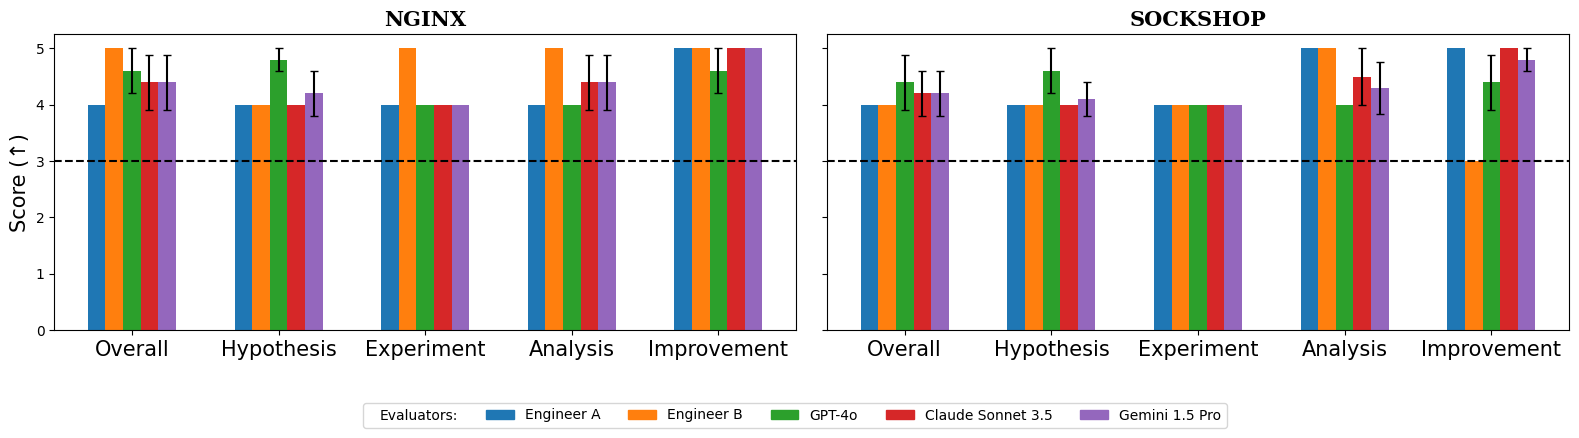

In [5]:
plot_side_by_side_bar_charts(data["nginx"], data["sockshop"], ["Nginx", "SockShop"])